In [1]:
import requests   
import json
import pprint
import numpy as np
import pandas as pd
from functools import reduce
from pandas.tools.plotting import scatter_matrix
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [2]:
#pd.options.display.max_rows = 3000
pd.options.display.max_columns = 40
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pylab import rcParams


#sns.set(style="ticks")
#sns.set_style("whitegrid")
#rcParams['figure.dpi'] = 180
#rcParams['lines.linewidth'] = 2
#rcParams['axes.facecolor'] = 'white'
#rcParams['patch.edgecolor'] = 'white'
#rcParams['font.family'] = 'StixGeneral'
#rcParams['figure.figsize'] = 7,5
#rcParams['font.size'] = 15

### 1.a Static Data

In [3]:
wh = pd.read_excel('WHRData.xls', index_col=0)
wh = wh.reset_index()
wh = wh.rename(columns={'Country name': 'country', 'Year': 'year'})

wh.head()

country  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008     3.723590            7.168690        0.450662   
1  Afghanistan  2009     4.401778            7.333790        0.552308   
2  Afghanistan  2010     4.758381            7.386629        0.539075   
3  Afghanistan  2011     3.831719            7.415019        0.521104   
4  Afghanistan  2012     3.782938            7.517126        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         50.799999                      0.718114    0.177889   
1                         51.200001                      0.678896    0.200178   
2                         51.599998                      0.600127    0.134353   
3                         51.919998                      0.495901    0.172137   
4                         52.240002                      0.530935    0.244273   

   Perceptions of corruption  Positive affect  Negative affect  \
0                   0.881686         0.517637         0.258195   
1                   0.850035         0.583926         0.237092   
2                   0.706766         0.618265         0.275324   
3                   0.731109         0.611387         0.267175   
4                   0.775620         0.710385         0.267919   

   Confidence in national government  Democratic Quality  Delivery Quality  \
0                           0.612072           -1.929690         -1.655084   
1                           0.611545           -2.044093         -1.635025   
2                           0.299357           -1.991810         -1.617176   
3                           0.307386           -1.919018         -1.616221   
4                           0.435440           -1.842996         -1.404078   

   Standard deviation of ladder by country-year  \
0                                      1.774662   
1                                      1.722688   
2                                      1.878622   
3                                      1.785360   
4                                      1.798283   

   Standard deviation/Mean of ladder by country-year  \
0                                           0.476600   
1                                           0.391362   
2                                           0.394803   
3                                           0.465942   
4                                           0.475367   

   GINI index (World Bank estimate)  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               NaN   
4                               NaN   

   GINI index (World Bank estimate), average 2000-16  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   gini of household income reported in Gallup, by wp5-year  \
0                                                NaN          
1                                           0.441906          
2                                           0.327318          
3                                           0.336764          
4                                           0.344540          

   Most people can be trusted, Gallup  \
0                                 NaN   
1                            0.286315   
2                            0.275833   
3                                 NaN   
4                                 NaN   

   Most people can be trusted, WVS round 1981-1984  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   Most people can be trusted, WVS round 1989-19

### 1.b Dynamic data (using world bank api)

In [4]:
class WorldBankDataFetcher:
    """
    """
    
    def __init__(self, indicators):
        self.indicators = indicators
        self.jsons = self.dataframes = []
        self.merged_data = None        

    def fetch_json_by(self, indicator):
        url = "http://api.worldbank.org/v2/countries/all/indicators/%s&format=json&per_page=9000" % (indicator + '?date=2000:2018')
        r = requests.get(url)    
        return json.loads(r.content)

    def json_to_df(self, j):
        indicator_name = j[1][0]['indicator']['value']
        df = pd.DataFrame.from_dict(j[1])
        df['country'] = df[['country']].applymap(lambda x : x['value'])
        df = df[['country', 'countryiso3code', 'date', 'value']]
        df.columns = ['country', 'code', 'year', indicator_name]
        return df
    
    def fetch(self):
        print('Note: this operation make take a while depending on the network status...\n...')      
        
        for i in indicators:
            self.jsons.append(self.fetch_json_by(i))
            progress = str(indicators.index(i)+1) + '/' + str(len(indicators))             
            print(' '.join([progress, 'Indicator', i]))
        
        print('Creating data frames...')
        self.dataframes = [self.json_to_df(j) for j in self.jsons]
        
        print('Merging data frames...')
        self.merged_data = reduce(lambda x, y: x.merge(y, how='outer', on=['country', 'code', 'year']), self.dataframes)        
        
        print('All done!')

### Indicators choosing process
* The featured indicator list can be found here: https://data.worldbank.org/indicator
* By clicking any of the indicator, a basic chart for this indicator can be found 
* Another priciple I followed is choose indicators that come from different sectors
* The chosen indicators was listed as below

In [5]:
indicators = [
    'AG.LND.FRST.K2',    # Forest area (sq. km)    
    'AG.LND.AGRI.ZS',    # Agricultural land (% of land area)
    'EG.ELC.ACCS.ZS',    # Access to electricity (% of population)    
    'EN.ATM.CO2E.PC',    # CO2 emissions (metric tons per capita)
    'MS.MIL.XPND.GD.ZS', # Military expenditure (% of GDP)
    'SL.UEM.TOTL.ZS',    # Unemployment, total (% of total labor force) (modeled ILO estimate)
    'SE.PRM.UNER.FE',    # Children out of school, primary, female
    'SP.POP.TOTL',       # Population, total
    'IS.AIR.DPRT',       # Air transport, registered carrier departures worldwide
    'IC.TAX.TOTL.CP.ZS', # Total tax rate (% of commercial profits)
    'NY.GDP.MKTP.KD.ZG', # GDP growth (annual %)
    'SE.ADT.LITR.ZS'     # Literacy rate, adult total (% of people ages 15 and above)
]

In [6]:
fetcher = WorldBankDataFetcher(indicators)
fetcher.fetch()

Note: this operation make take a while depending on the network status...
...
1/12 Indicator AG.LND.FRST.K2
2/12 Indicator AG.LND.AGRI.ZS
3/12 Indicator EG.ELC.ACCS.ZS
4/12 Indicator EN.ATM.CO2E.PC
5/12 Indicator MS.MIL.XPND.GD.ZS
6/12 Indicator SL.UEM.TOTL.ZS
7/12 Indicator SE.PRM.UNER.FE
8/12 Indicator SP.POP.TOTL
9/12 Indicator IS.AIR.DPRT
10/12 Indicator IC.TAX.TOTL.CP.ZS
11/12 Indicator NY.GDP.MKTP.KD.ZG
12/12 Indicator SE.ADT.LITR.ZS
Creating data frames...
Merging data frames...
All done!


In [7]:
wb = fetcher.merged_data
wb['year'] =  pd.to_numeric(wb['year'])
wb = wb[wb.code!='']
wb = wb.drop('code', axis=1)

wb.head()

country  year  Forest area (sq. km)  \
893  Afghanistan  2018                   NaN   
894  Afghanistan  2017                   NaN   
895  Afghanistan  2016               13500.0   
896  Afghanistan  2015               13500.0   
897  Afghanistan  2014               13500.0   

     Agricultural land (% of land area)  \
893                                 NaN   
894                                 NaN   
895                            58.06758   
896                            58.06758   
897                            58.06758   

     Access to electricity (% of population)  \
893                                      NaN   
894                                      NaN   
895                                84.137138   
896                                71.500000   
897                                89.500000   

     CO2 emissions (metric tons per capita)  Military expenditure (% of GDP)  \
893                                     NaN                              NaN   
894                                     NaN                         0.906857   
895                                     NaN                         0.955493   
896                                     NaN                         0.993455   
897                                0.299445                         1.298013   

     Unemployment, total (% of total labor force) (modeled ILO estimate)  \
893                                              1.542                     
894                                              1.559                     
895                                              1.634                     
896                                              1.679                     
897                                              1.735                     

     Children out of school, primary, female  Population, total  \
893                                      NaN                NaN   
894                                      NaN         35530081.0   
895                                      NaN         34656032.0   
896                                      NaN         33736494.0   
897                                      NaN         32758020.0   

     Air transport, registered carrier departures worldwide  \
893                                                NaN        
894                                            23682.0        
895                                            22770.0        
896                                            23532.0        
897                                            25920.0        

     Total tax and contribution rate (% of profit)  GDP growth (annual %)  \
893                                           71.4                    NaN   
894                                           71.4               2.665292   
895                                           47.9               2.260314   
896                                           36.1               1.451315   
897                                           36.1               2.724543   

     Literacy rate, adult total (% of people ages 15 and above)  
893                                                NaN           
894                                                NaN           
895                                                NaN           
896                                                NaN           
897                                                NaN

### 1.c Integration

* Construct a contry name dictionary by looking at the set differnence between the two data frames
* Use the contry name dictionary to make the country name consisteny between the two data frames
* Merge the two data frames into a single one

In [8]:
set(wh.country).difference(set(wb.country))

{'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Egypt',
 'Gambia',
 'Hong Kong S.A.R. of China',
 'Iran',
 'Ivory Coast',
 'Kyrgyzstan',
 'Laos',
 'Macedonia',
 'North Cyprus',
 'Palestinian Territories',
 'Russia',
 'Slovakia',
 'Somaliland region',
 'South Korea',
 'Swaziland',
 'Syria',
 'Taiwan Province of China',
 'Venezuela',
 'Yemen'}

In [9]:
set(wb.country).difference(set(wh.country))

{'American Samoa',
 'Andorra',
 'Antigua and Barbuda',
 'Aruba',
 'Bahamas, The',
 'Barbados',
 'Bermuda',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Cabo Verde',
 'Cayman Islands',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Curacao',
 'Dominica',
 'Egypt, Arab Rep.',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Faroe Islands',
 'Fiji',
 'French Polynesia',
 'Gambia, The',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Guinea-Bissau',
 'Hong Kong SAR, China',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Liechtenstein',
 'Macao SAR, China',
 'Maldives',
 'Marshall Islands',
 'Micronesia, Fed. Sts.',
 'Monaco',
 'Nauru',
 'New Caledonia',
 'North Macedonia',
 'Northern Mariana Islands',
 'Palau',
 'Papua New Guinea',
 'Puerto Rico',
 'Russian Federation',
 'Samoa',
 'San Marino',
 'Sao Tome and Principe',
 'Seychelles',
 'Sint Maarten (Dutch part)',
 'S

In [10]:
country_names = {
    
    'Congo (Brazzaville)' : 'Congo, Rep.',
    
    'Congo (Kinshasa)' : 'Congo, Dem. Rep.',
    
    'Egypt' : 'Egypt, Arab Rep.',
    
    'Gambia': 'Gambia, The',
    
    'Hong Kong S.A.R. of China' : 'Hong Kong SAR, China',
    
    'Iran' : 'Iran, Islamic Rep.',
    
    'Ivory Coast' : "Cote d'Ivoire",
    
    'Kyrgyzstan' : 'Kyrgyz Republic',
    
    'Laos' : 'Lao PDR',
    
    'Macedonia': 'North Macedonia',
    
    'Palestinian Territories' : 'West Bank and Gaza',
    
    'Russia' : 'Russian Federation',
    
    'Slovakia' : 'Slovak Republic',
    
    'South Korea' : 'Korea, Rep.',
        
    'Swaziland': 'Eswatini',
    
    'Syria' : 'Syrian Arab Republic',
    
    'Venezuela' : 'Venezuela, RB',
    
    'Yemen' : 'Yemen, Rep.'
    
}

country_names = {v:k for k, v in country_names.items()}
country_names

{'Congo, Dem. Rep.': 'Congo (Kinshasa)',
 'Congo, Rep.': 'Congo (Brazzaville)',
 "Cote d'Ivoire": 'Ivory Coast',
 'Egypt, Arab Rep.': 'Egypt',
 'Eswatini': 'Swaziland',
 'Gambia, The': 'Gambia',
 'Hong Kong SAR, China': 'Hong Kong S.A.R. of China',
 'Iran, Islamic Rep.': 'Iran',
 'Korea, Rep.': 'South Korea',
 'Kyrgyz Republic': 'Kyrgyzstan',
 'Lao PDR': 'Laos',
 'North Macedonia': 'Macedonia',
 'Russian Federation': 'Russia',
 'Slovak Republic': 'Slovakia',
 'Syrian Arab Republic': 'Syria',
 'Venezuela, RB': 'Venezuela',
 'West Bank and Gaza': 'Palestinian Territories',
 'Yemen, Rep.': 'Yemen'}

In [11]:
wb = wb.applymap(lambda x: country_names[x] if x in country_names else x)

In [12]:
set(wh.country).difference(set(wb.country))

{'North Cyprus', 'Somaliland region', 'Taiwan Province of China'}

#### Pre-integration check

In [13]:
len(wh)

1704

#### Integration

In [14]:
integrated = wh.merge(wb, how='left', on=['country', 'year'])

#### Post-integration check

In [15]:
len(integrated)

1704

In [16]:
integrated.head()

country  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008     3.723590            7.168690        0.450662   
1  Afghanistan  2009     4.401778            7.333790        0.552308   
2  Afghanistan  2010     4.758381            7.386629        0.539075   
3  Afghanistan  2011     3.831719            7.415019        0.521104   
4  Afghanistan  2012     3.782938            7.517126        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         50.799999                      0.718114    0.177889   
1                         51.200001                      0.678896    0.200178   
2                         51.599998                      0.600127    0.134353   
3                         51.919998                      0.495901    0.172137   
4                         52.240002                      0.530935    0.244273   

   Perceptions of corruption  Positive affect  Negative affect  \
0                   0.881686         0.517637         0.258195   
1                   0.850035         0.583926         0.237092   
2                   0.706766         0.618265         0.275324   
3                   0.731109         0.611387         0.267175   
4                   0.775620         0.710385         0.267919   

   Confidence in national government  Democratic Quality  Delivery Quality  \
0                           0.612072           -1.929690         -1.655084   
1                           0.611545           -2.044093         -1.635025   
2                           0.299357           -1.991810         -1.617176   
3                           0.307386           -1.919018         -1.616221   
4                           0.435440           -1.842996         -1.404078   

   Standard deviation of ladder by country-year  \
0                                      1.774662   
1                                      1.722688   
2                                      1.878622   
3                                      1.785360   
4                                      1.798283   

   Standard deviation/Mean of ladder by country-year  \
0                                           0.476600   
1                                           0.391362   
2                                           0.394803   
3                                           0.465942   
4                                           0.475367   

   GINI index (World Bank estimate)  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               NaN   
4                               NaN   

   GINI index (World Bank estimate), average 2000-16  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   gini of household income reported in Gallup, by wp5-year  \
0                                                NaN          
1                                           0.441906          
2                                           0.327318          
3                                           0.336764          
4                                           0.344540          

   Most people can be trusted, Gallup  \
0                                 NaN   
1                            0.286315   
2                            0.275833   
3                                 NaN   
4                                 NaN   

   Most people can be trusted, WVS round 1981-1984  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

   Most people can be trusted, WVS round 1989-19

#### Since the row count of the integrated data frame is equae to the World Happniess Report data frame, hence no data point was lost duing this mergeing.

### 2.a EDA – data quality inspection 

* Check null value count for each column
* Check and drop, if necessary, duplicate rows
* Drop columns with less than 1500 non-null values
* Drop rows with any null values
* Check target variable distribution and transform it if necessary

In [17]:
integrated.isnull().sum().sum()

16116

In [18]:
integrated.isnull().sum()

country                                                                   0
year                                                                      0
Life Ladder                                                               0
Log GDP per capita                                                       28
Social support                                                           13
Healthy life expectancy at birth                                         28
Freedom to make life choices                                             29
Generosity                                                               82
Perceptions of corruption                                                96
Positive affect                                                          19
Negative affect                                                          13
Confidence in national government                                       174
Democratic Quality                                                      146
Delivery Qua

In [19]:
integrated.duplicated().any()

False

In [20]:
dropped = integrated.dropna(axis='columns', thresh=1500)
dropped = dropped.dropna(axis='index', thresh=len(dropped.columns))
dropped.isnull().sum().sum()

0

In [21]:
dropped.isnull().sum()

country                                                                0
year                                                                   0
Life Ladder                                                            0
Log GDP per capita                                                     0
Social support                                                         0
Healthy life expectancy at birth                                       0
Freedom to make life choices                                           0
Generosity                                                             0
Perceptions of corruption                                              0
Positive affect                                                        0
Negative affect                                                        0
Confidence in national government                                      0
Democratic Quality                                                     0
Delivery Quality                                   

In [22]:
dropped = dropped.reset_index(drop=True)
dropped = dropped.loc[:, dropped.columns != 'country']
dropped.head()

year  Life Ladder  Log GDP per capita  Social support  \
0  2007     4.634252            9.077331        0.821372   
1  2012     5.510124            9.246655        0.784502   
2  2013     4.550648            9.258445        0.759477   
3  2014     4.813763            9.278104        0.625587   
4  2015     4.606651            9.302960        0.639356   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         65.800003                      0.528605   -0.014393   
1                         66.959999                      0.601512   -0.172262   
2                         67.239998                      0.631830   -0.130645   
3                         67.519997                      0.734648   -0.028162   
4                         67.800003                      0.703851   -0.084411   

   Perceptions of corruption  Positive affect  Negative affect  \
0                   0.874700         0.552678         0.246335   
1                   0.847675         0.606636         0.271393   
2                   0.862905         0.633609         0.338379   
3                   0.882704         0.684911         0.334543   
4                   0.884793         0.688370         0.350427   

   Confidence in national government  Democratic Quality  Delivery Quality  \
0                           0.300681           -0.045108         -0.420024   
1                           0.364894           -0.060784         -0.328862   
2                           0.338095            0.070411         -0.330956   
3                           0.498786            0.314873         -0.187407   
4                           0.506978            0.251629         -0.152544   

   Standard deviation of ladder by country-year  \
0                                      1.764947   
1                                      1.921203   
2                                      2.315580   
3                                      2.660069   
4                                      2.729001   

   Standard deviation/Mean of ladder by country-year  \
0                                           0.380848   
1                                           0.348668   
2                                           0.508846   
3                                           0.552597   
4                                           0.592405   

   GINI index (World Bank estimate), average 2000-16  \
0                                            0.30325   
1                                            0.30325   
2                                            0.30325   
3                                            0.30325   
4                                            0.30325   

   Unemployment, total (% of total labor force) (modeled ILO estimate)  \
0                                             15.966                     
1                                             13.376                     
2                                             15.866                     
3                                             17.490                     
4                                             17.080                     

   Population, total  Total tax and contribution rate (% of profit)  \
0          2970017.0                                           46.3   
1          2900401.0                                           38.8   
2          2895092.0                                           31.7   
3          2889104.0                                           31.6   
4          2880703.0                                           36.9   

   GDP growth (annual %)  
0                   5.98  
1                   1.42  
2                   1.00  
3                   1.77  
4                   2.22

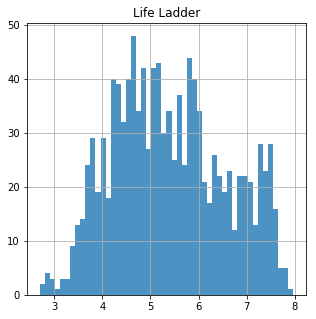

In [145]:
data = dropped.copy()
data['year'] = data['year'] - 2000
_ = data[['Life Ladder']].hist(bins=50, figsize=(5,5), alpha=0.8)
plt.show()

 * As one of the assumptions that Linear Regresion model need meet, target variable should be normal distribution. 
 * As shown above, the distribution of the indicator Life Ladder basicly is a normal distribution. Thus, it is not necessary to transform it.

### 2.b EDA – the search for good predictors (12 marks)
* Rename columns such that the data set is better for visualization
* Draw histogram plot for each feature and choose features that comform to normal distribution
* Draw scatter matrix and correlation matrix to choose features that are correlated to happniess and not quite correlated between them.

In [146]:
name_table = {
    'Life Ladder': 'happiniess', 
    'Log GDP per capita': 'gdp_pc',
    'Social support': 'support',
    'Population, total': 'pop',
    'Total tax and contribution rate (% of profit)': 'tax',
    'GDP growth (annual %)': 'gdp_g',
    'Healthy life expectancy at birth': 'life_expected',
    'Freedom to make life choices': 'choice',
    'Generosity': 'generosity',
    'Perceptions of corruption': 'corruption',
    'Positive affect': 'positive',
    'Negative affect': 'negative',
    'Confidence in national government': 'gov_confidence',
    'Democratic Quality': 'democoratic',
    'Delivery Quality': 'delivery',
    'Standard deviation of ladder by country-year': 'sd_country_year',
    'Standard deviation/Mean of ladder by country-year': 'sd_m_country_year',
    'GINI index (World Bank estimate), average 2000-16': 'gini',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'unemployment'
}
data = data.rename(columns=name_table)
data.head()

year  happiniess    gdp_pc   support  life_expected    choice  generosity  \
0     7    4.634252  9.077331  0.821372      65.800003  0.528605   -0.014393   
1    12    5.510124  9.246655  0.784502      66.959999  0.601512   -0.172262   
2    13    4.550648  9.258445  0.759477      67.239998  0.631830   -0.130645   
3    14    4.813763  9.278104  0.625587      67.519997  0.734648   -0.028162   
4    15    4.606651  9.302960  0.639356      67.800003  0.703851   -0.084411   

   corruption  positive  negative  gov_confidence  democoratic  delivery  \
0    0.874700  0.552678  0.246335        0.300681    -0.045108 -0.420024   
1    0.847675  0.606636  0.271393        0.364894    -0.060784 -0.328862   
2    0.862905  0.633609  0.338379        0.338095     0.070411 -0.330956   
3    0.882704  0.684911  0.334543        0.498786     0.314873 -0.187407   
4    0.884793  0.688370  0.350427        0.506978     0.251629 -0.152544   

   sd_country_year  sd_m_country_year     gini  unemployment        pop   tax  \
0         1.764947           0.380848  0.30325        15.966  2970017.0  46.3   
1         1.921203           0.348668  0.30325        13.376  2900401.0  38.8   
2         2.315580           0.508846  0.30325        15.866  2895092.0  31.7   
3         2.660069           0.552597  0.30325        17.490  2889104.0  31.6   
4         2.729001           0.592405  0.30325        17.080  2880703.0  36.9   

   gdp_g  
0   5.98  
1   1.42  
2   1.00  
3   1.77  
4   2.22

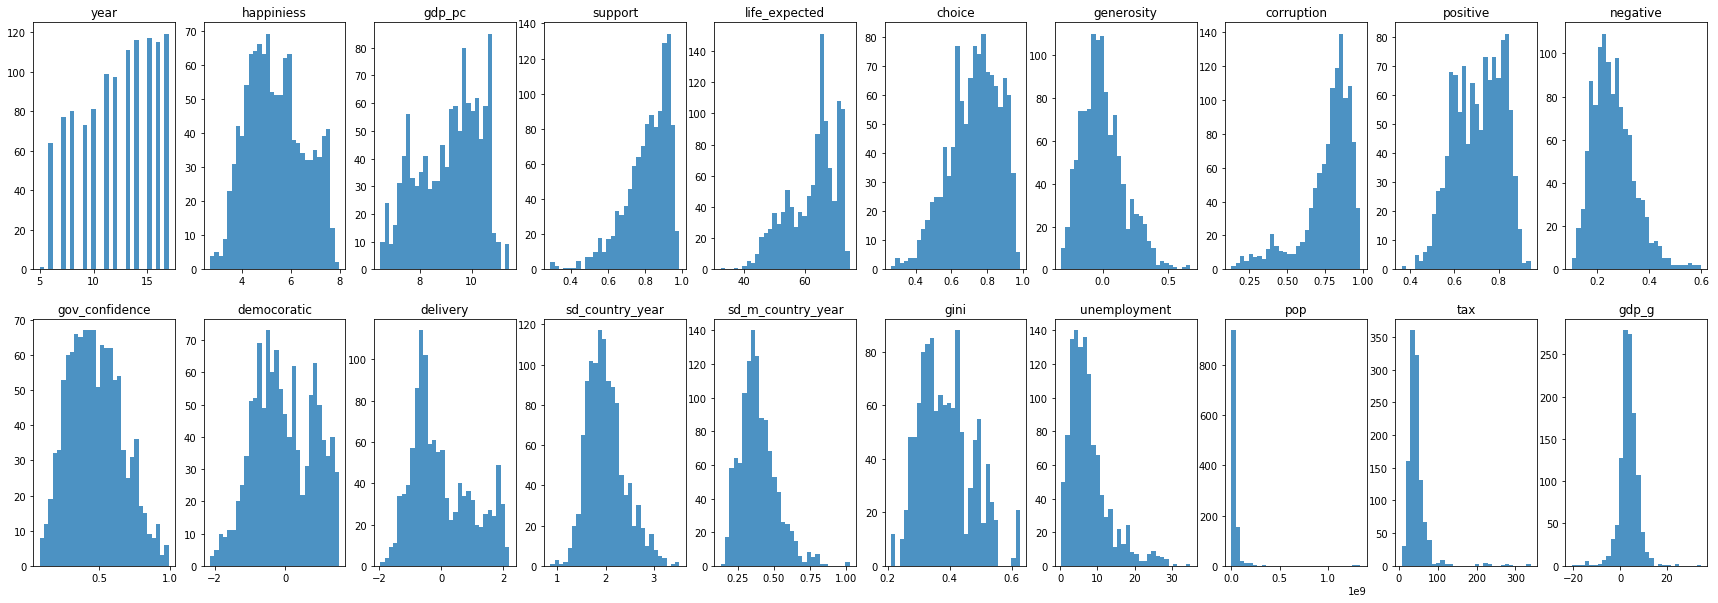

In [147]:
f, ax = plt.subplots(2, 10, figsize=(30, 10))

for i in range(0, len(data.columns)):
    c = 10
    f = data.columns[i]
    sub = ax[i//c, i%c]
    sub.hist(data[f], bins=30, alpha=0.8)
    sub.set_title(f)
plt.show()    

* Feartures **year**, **pop** and **tax** are dropped since they are extremely skewed 

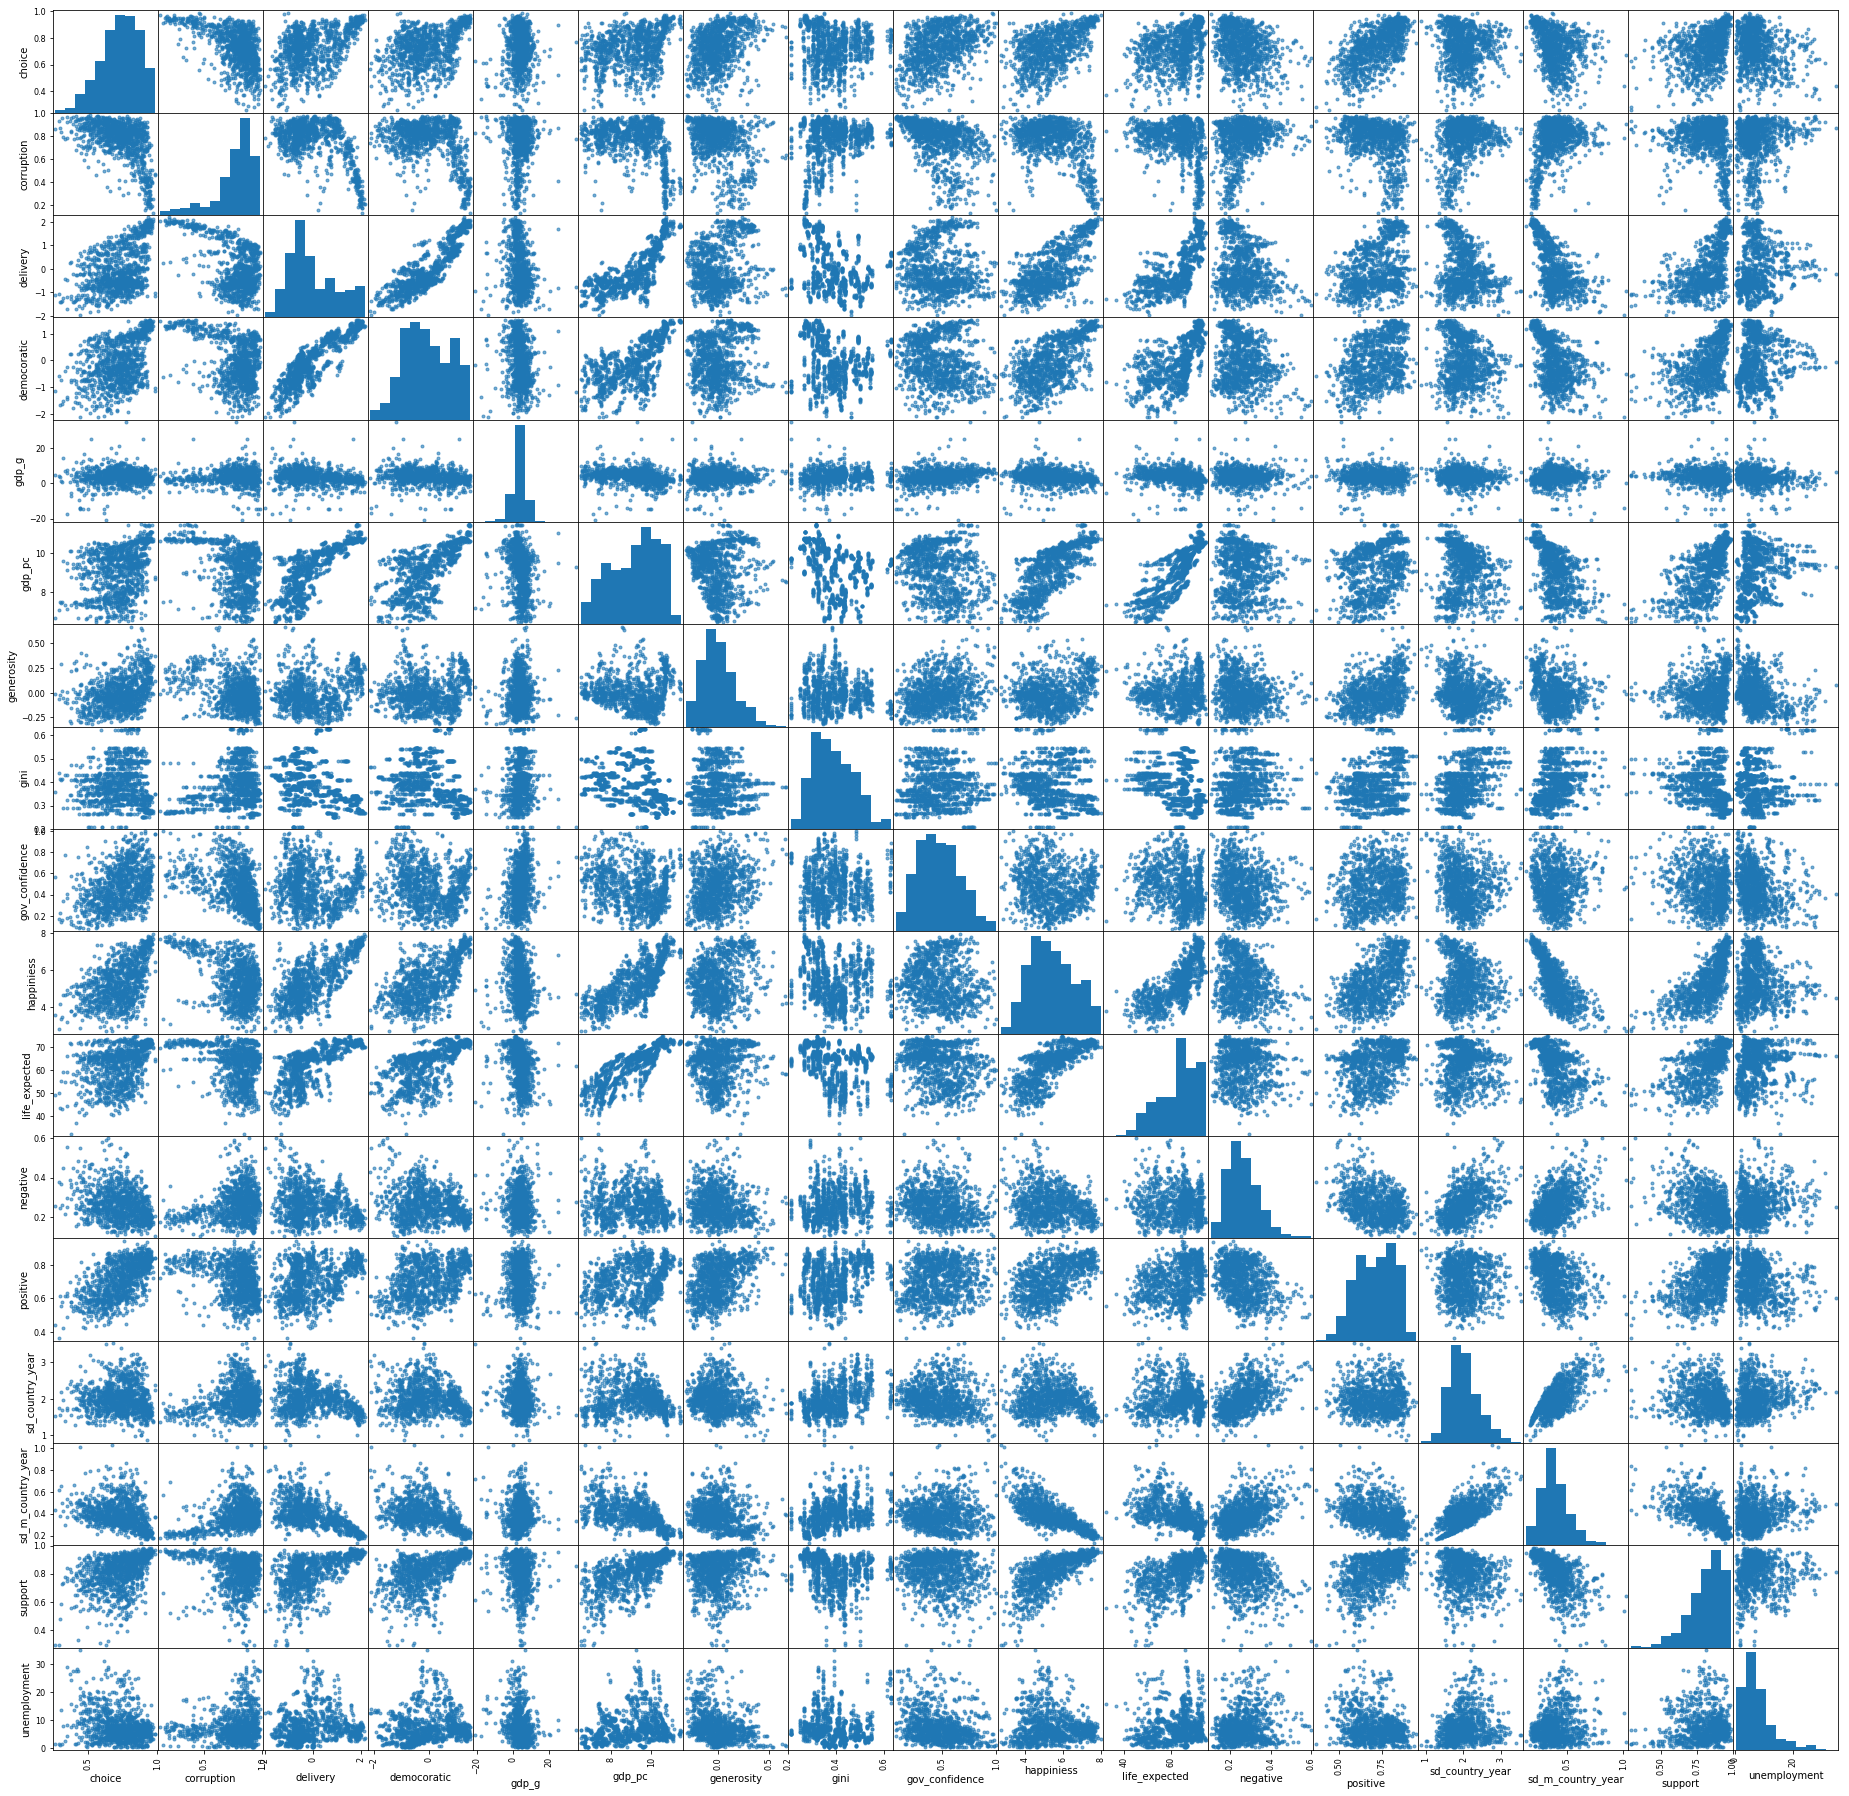

In [152]:
_ = scatter_matrix(data[data.columns.difference(['pop', 'tax', 'year'])], alpha=0.6, figsize=(32, 32))
plt.show()

In [151]:
data[data.columns.difference(['pop', 'tax', 'year'])].corr()

choice  corruption  delivery  democoratic     gdp_g  \
choice             1.000000   -0.522109  0.495913     0.468219  0.047246   
corruption        -0.522109    1.000000 -0.540817    -0.395507  0.038378   
delivery           0.495913   -0.540817  1.000000     0.880904 -0.220068   
democoratic        0.468219   -0.395507  0.880904     1.000000 -0.196255   
gdp_g              0.047246    0.038378 -0.220068    -0.196255  1.000000   
gdp_pc             0.370837   -0.338150  0.798885     0.696758 -0.251740   
generosity         0.375087   -0.331697  0.218686     0.119209  0.043234   
gini               0.010328    0.245682 -0.358979    -0.240318  0.117989   
gov_confidence     0.402482   -0.422003 -0.070721    -0.153750  0.276211   
happiniess         0.549379   -0.464561  0.729272     0.641187 -0.177877   
life_expected      0.380844   -0.309077  0.717943     0.616825 -0.232893   
negative          -0.276404    0.255493 -0.246115    -0.227216 -0.056944   
positive           0.612966   -0.335740  0.377957     0.394266 -0.035028   
sd_country_year   -0.050256    0.287571 -0.276500    -0.167957 -0.097112   
sd_m_country_year -0.349495    0.385362 -0.592745    -0.482026  0.014304   
support            0.412240   -0.214412  0.565458     0.547639 -0.130820   
unemployment      -0.254771    0.127145  0.111509     0.116708 -0.218060   

                     gdp_pc  generosity      gini  gov_confidence  happiniess  \
choice             0.370837    0.375087  0.010328        0.402482    0.549379   
corruption        -0.338150   -0.331697  0.245682       -0.422003   -0.464561   
delivery           0.798885    0.218686 -0.358979       -0.070721    0.729272   
democoratic        0.696758    0.119209 -0.240318       -0.153750    0.641187   
gdp_g             -0.251740    0.043234  0.117989        0.276211   -0.177877   
gdp_pc             1.000000    0.025104 -0.343128       -0.193890    0.782985   
generosity         0.025104    1.000000 -0.083007        0.257021    0.251401   
gini              -0.343128   -0.083007  1.000000        0.035174   -0.207565   
gov_confidence    -0.193890    0.257021  0.035174        1.000000   -0.099048   
happiniess         0.782985    0.251401 -0.207565       -0.099048    1.000000   
life_expected      0.856864    0.073415 -0.343839       -0.216427    0.766239   
negative          -0.125721   -0.157738  0.131946       -0.182298   -0.243818   
positive           0.326417    0.396977  0.269180        0.139296    0.567479   
sd_country_year   -0.109923   -0.167642  0.397650       -0.146221   -0.164790   
sd_m_country_year -0.574851   -0.207309  0.352812        0.021928   -0.757231   
support            0.670213    0.131232 -0.173975       -0.173755    0.713091   
unemployment       0.215858   -0.314030  0.013099       -0.243568   -0.073549   

                   life_expected  negative  positive  sd_country_year  \
choice                  0.380844 -0.276404  0.612966        -0.050256   
corruption             -0.309077  0.255493 -0.335740         0.287571   
delivery                0.717943 -0.246115  0.377957        -0.276500   
democoratic             0.616825 -0.227216  0.394266        -0.167957   
gdp_g                  -0.232893 -0.056944 -0.035028        -0.097112   
gdp_pc                  0.856864 -0.125721  0.326417        -0.109923   
generosity              0.073415 -0.157738  0.396977        -0.167642   
gini                   -0.343839  0.131946  0.269180         0.397650   
gov_confidence         -0.216427 -0.182298  0.139296        -0.146221   
happiniess              0.766239 -0.243818  0.567479        -0.164790   
life_expected           1.000000 -0.092510  0.373963        -0.045069   
negative               -0.092510  1.000000 -0.356025         0.523227   
positive                0.373963 -0.356025  1.000000        -0.033713   
sd_country_year        -0.045069  0.523227 -0.033713         1.000000   
sd_m_country_year      -0.536073  0.500874 -0.387933         0.720153   
support                 0

### Discuss
* As shown above, features **gov_confidence** and **unemployment** have low correlations to happniess. Thus, the two feature should not be chosen.
* All three features **delivery** , **democoratic** and **gdp_pc** indicate high correlations to happniess. However, the correlations among them are also very high. To preven multicollinearity, only one should be chosen
* Based on the above the chosen features are listed below:

In [155]:
chosen_fearues = [
    'happiniess', 
    'gdp_pc', 
    'support', 
    'life_expected', 
    'choice',
    'generosity', 
    'corruption', 
    'positive', 
    'negative', 
    'sd_country_year', 
    'sd_m_country_year',
    'gini', 
    'gdp_g'
]

### Task 3

In [156]:
fs1 = ['year', 'gdp_pc', 'support', 'pop', 'tax', 'gdp_g', 'life_expected', 'choice', 'generosity', 'corruption', 'positive', 'negative', 'gov_confidence', 'democoratic', 'delivery', 'sd_country_year', 'sd_m_country_year', 'gini', 'unemployment']

#fs2 = [s[0] + ' + ' + s[1] for s in set([(x, y) if x > y else (y, x)  for x in fs1 for y in [z for z in fs1 if z != x] ])]


#fs = fs1 + fs2
print(fs1)
print(chosen_fearues)

['year', 'gdp_pc', 'support', 'pop', 'tax', 'gdp_g', 'life_expected', 'choice', 'generosity', 'corruption', 'positive', 'negative', 'gov_confidence', 'democoratic', 'delivery', 'sd_country_year', 'sd_m_country_year', 'gini', 'unemployment']
['happiniess', 'gdp_pc', 'support', 'life_expected', 'choice', 'generosity', 'corruption', 'positive', 'negative', 'sd_country_year', 'sd_m_country_year', 'gini', 'gdp_g']


                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.244
Date:                Thu, 09 May 2019   Prob (F-statistic):             0.0126
Time:                        16:08:57   Log-Likelihood:                -1804.1
No. Observations:                1150   AIC:                             3612.
Df Residuals:                    1148   BIC:                             3622.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        5.5228      0.059     92.962   

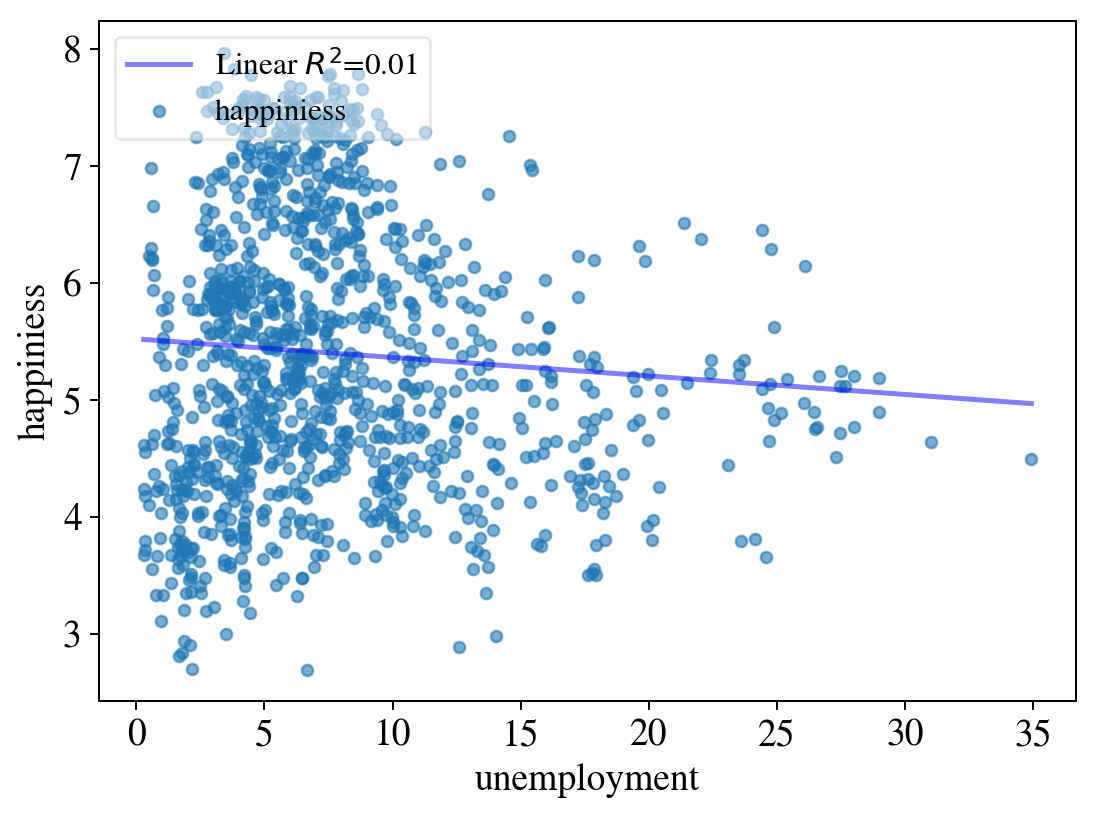






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     51.69
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.17e-12
Time:                        16:08:58   Log-Likelihood:                -1781.9
No. Observations:                1150   AIC:                             3568.
Df Residuals:                    1148   BIC:                             3578.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.5126      0.158     41.177    

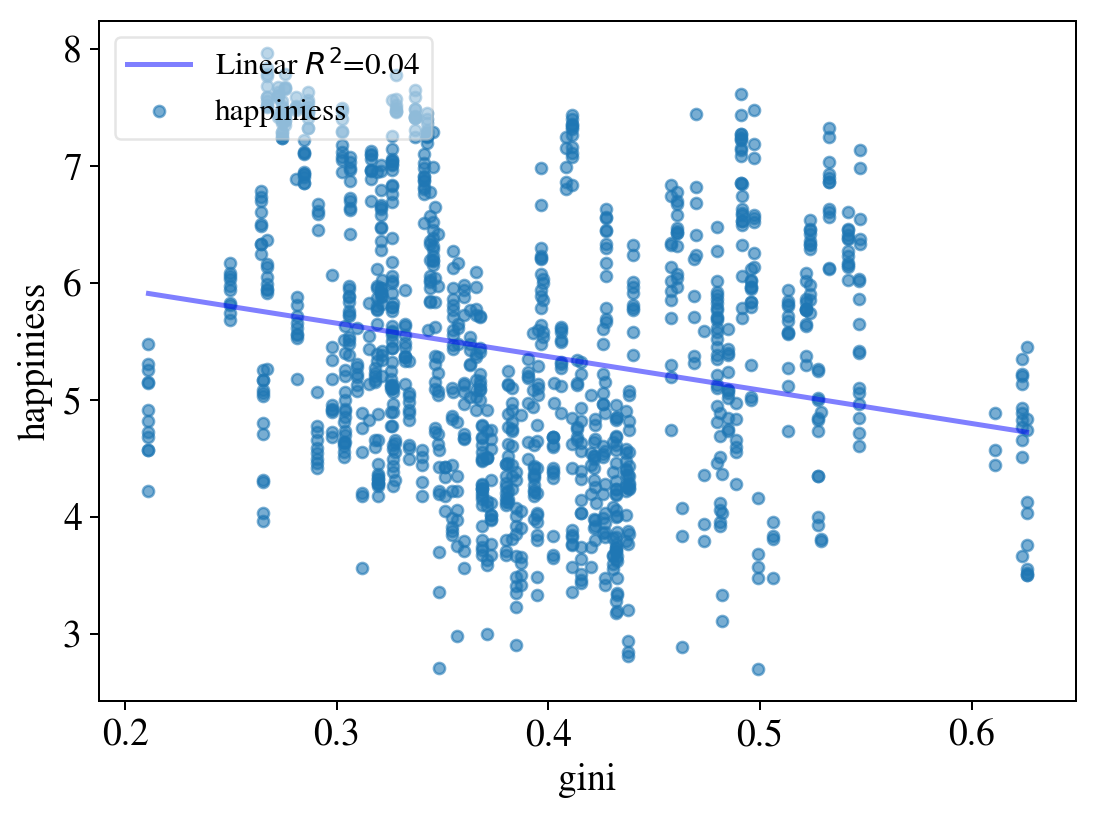






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1543.
Date:                Thu, 09 May 2019   Prob (F-statistic):          1.33e-214
Time:                        16:08:58   Log-Likelihood:                -1317.4
No. Observations:                1150   AIC:                             2639.
Df Residuals:                    1148   BIC:                             2649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             8.1831     

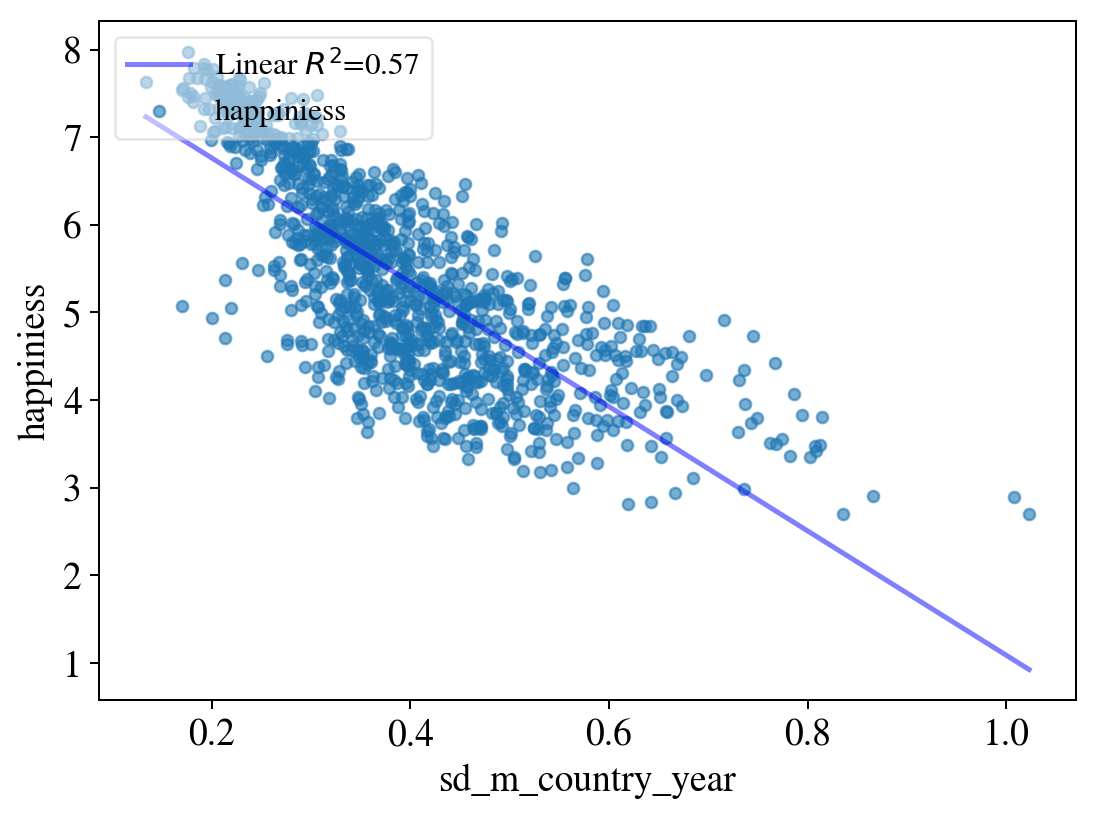






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     32.04
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.90e-08
Time:                        16:08:59   Log-Likelihood:                -1791.4
No. Observations:                1150   AIC:                             3587.
Df Residuals:                    1148   BIC:                             3597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           6.3766      0.176

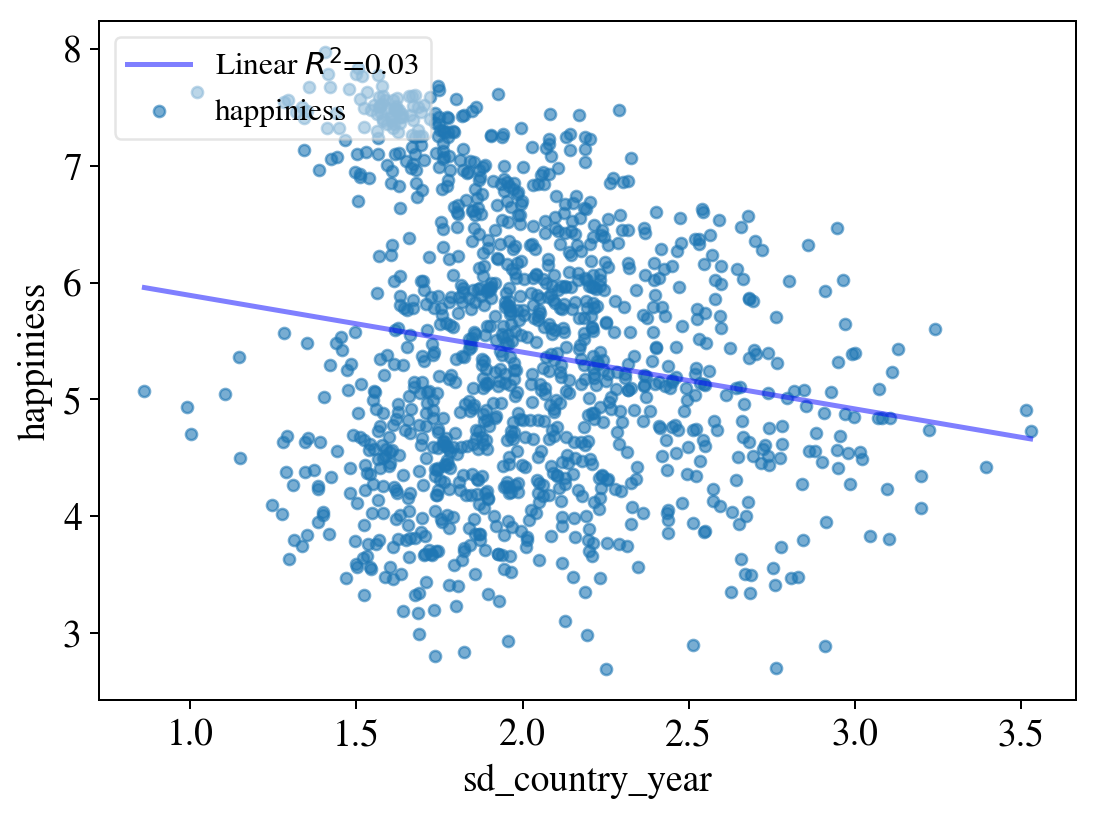






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1304.
Date:                Thu, 09 May 2019   Prob (F-statistic):          2.07e-191
Time:                        16:09:00   Log-Likelihood:                -1370.8
No. Observations:                1150   AIC:                             2746.
Df Residuals:                    1148   BIC:                             2756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.3911      0.024    229.171    

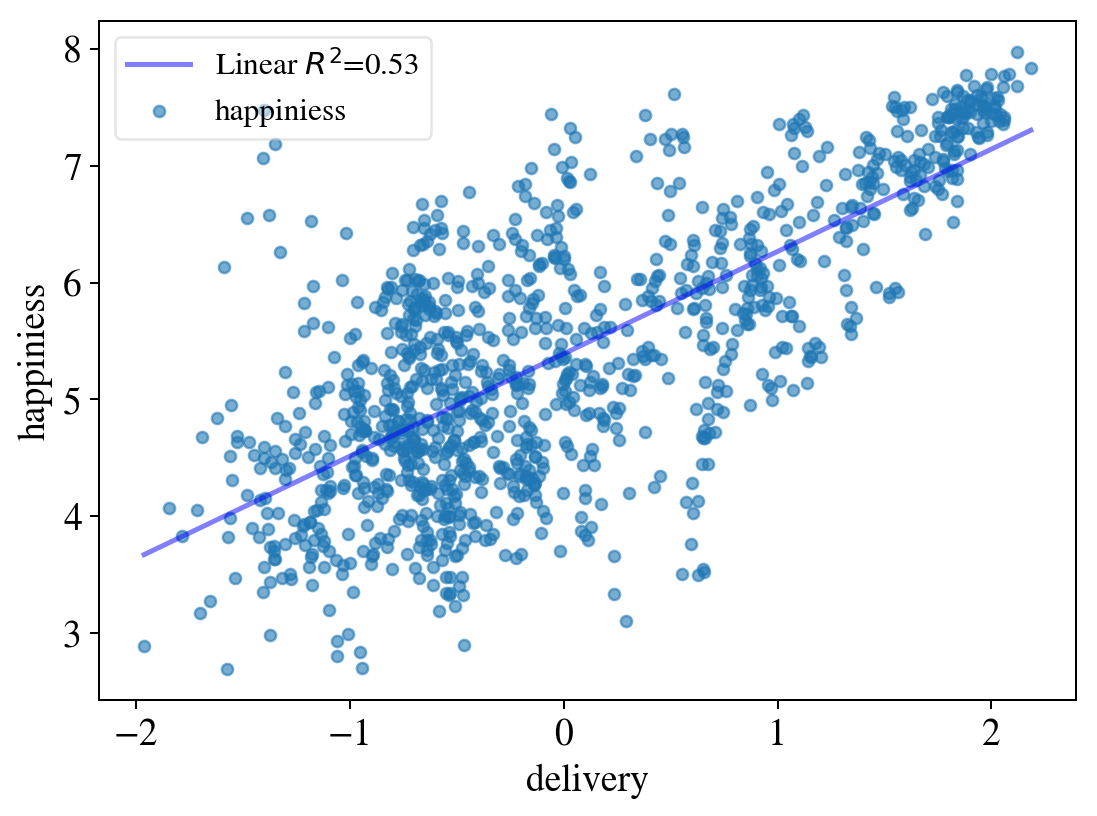






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     801.5
Date:                Thu, 09 May 2019   Prob (F-statistic):          3.63e-134
Time:                        16:09:01   Log-Likelihood:                -1502.7
No. Observations:                1150   AIC:                             3009.
Df Residuals:                    1148   BIC:                             3020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       5.4355      0.026    205.823 

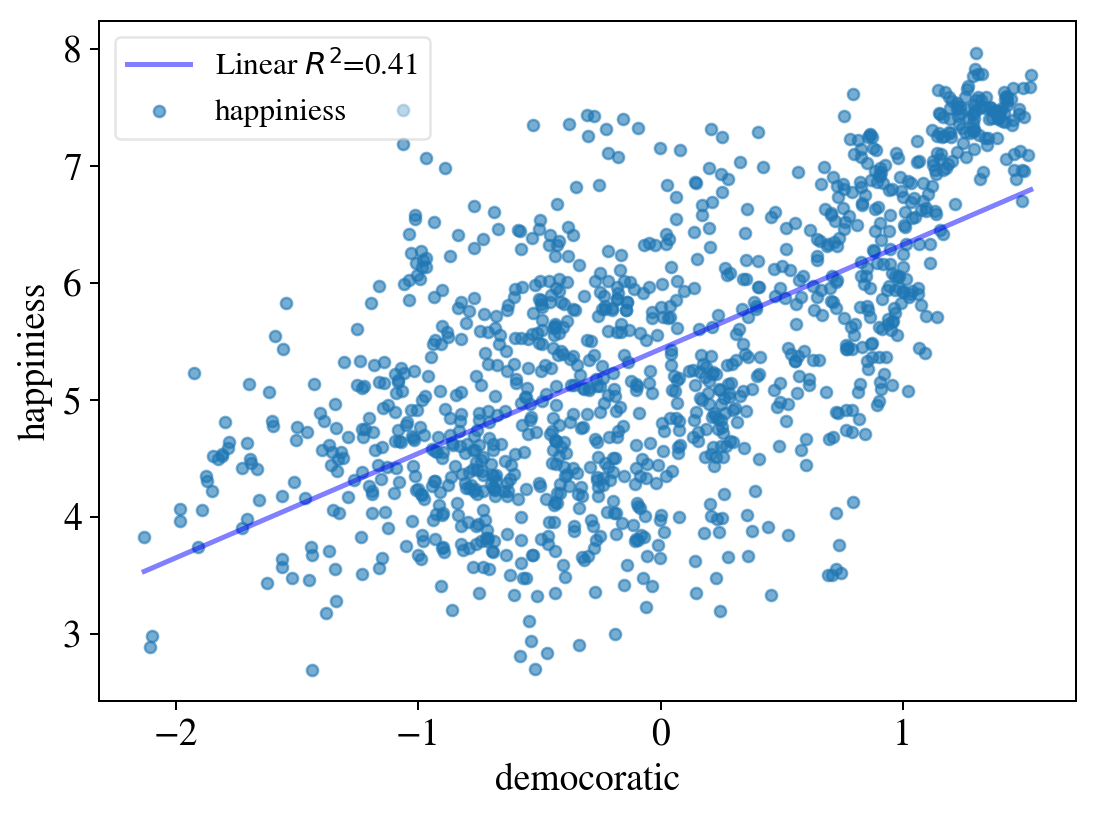






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.37
Date:                Thu, 09 May 2019   Prob (F-statistic):           0.000770
Time:                        16:09:02   Log-Likelihood:                -1801.6
No. Observations:                1150   AIC:                             3607.
Df Residuals:                    1148   BIC:                             3617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          5.6904      0.092   

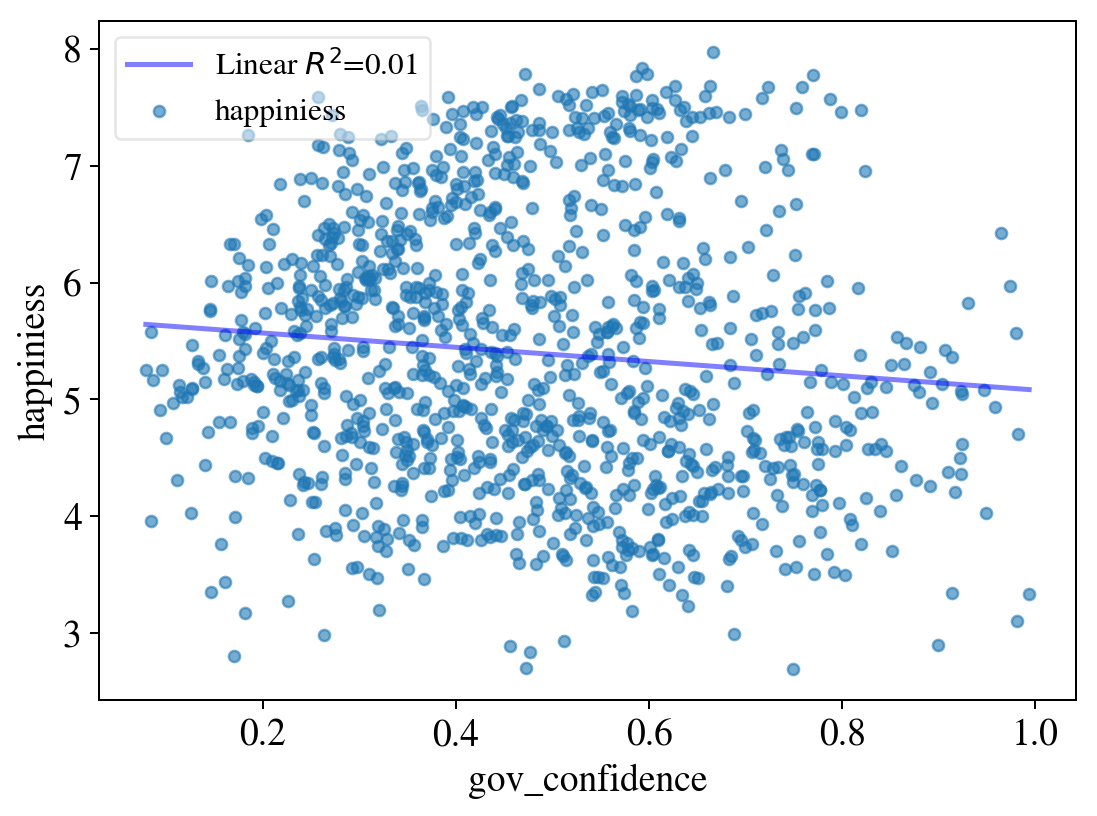






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     72.56
Date:                Thu, 09 May 2019   Prob (F-statistic):           5.02e-17
Time:                        16:09:03   Log-Likelihood:                -1772.0
No. Observations:                1150   AIC:                             3548.
Df Residuals:                    1148   BIC:                             3558.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.3395      0.115     55.101    

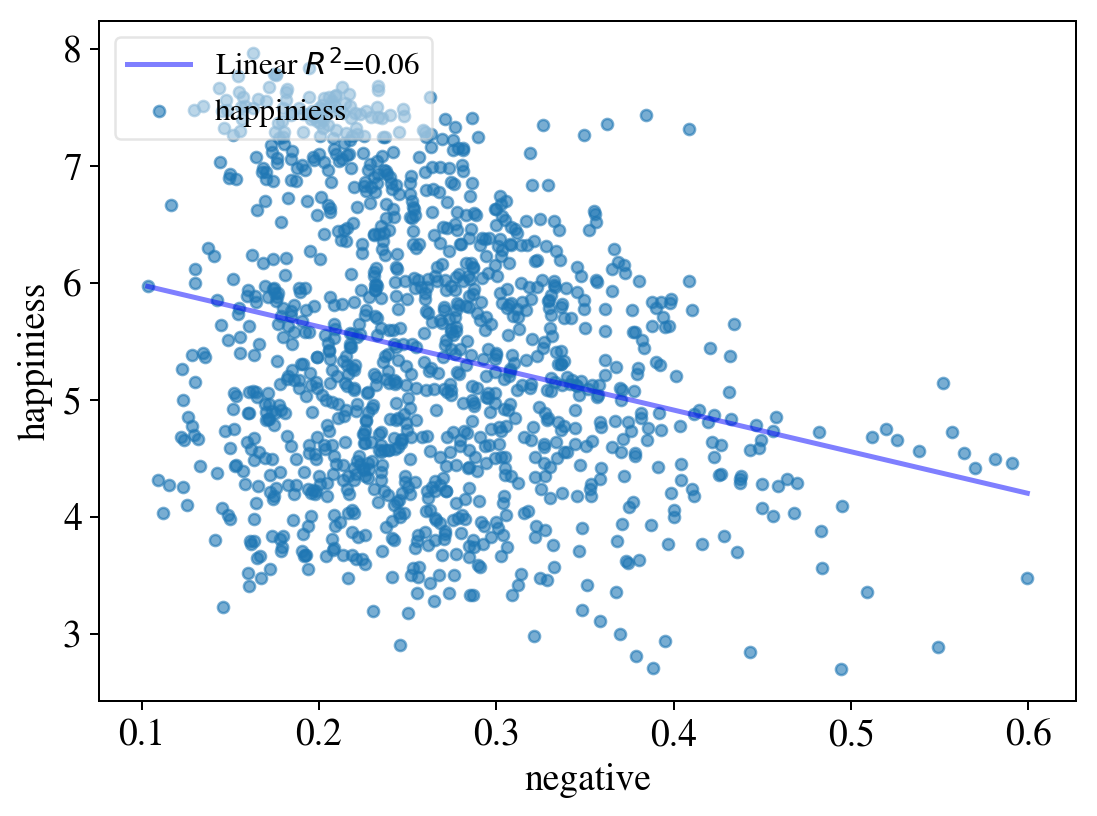






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     545.3
Date:                Thu, 09 May 2019   Prob (F-statistic):           5.38e-99
Time:                        16:09:03   Log-Likelihood:                -1583.7
No. Observations:                1150   AIC:                             3171.
Df Residuals:                    1148   BIC:                             3182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0652      0.188      5.671    

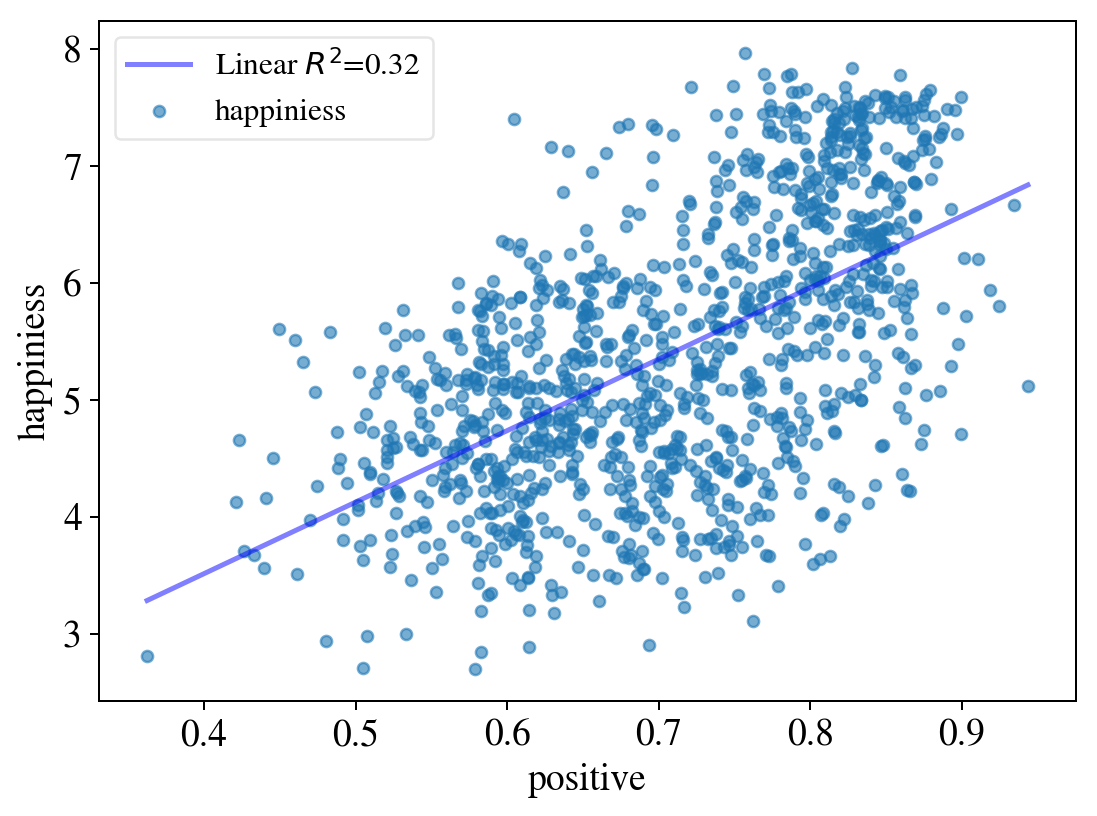






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     315.9
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.26e-62
Time:                        16:09:04   Log-Likelihood:                -1667.4
No. Observations:                1150   AIC:                             3339.
Df Residuals:                    1148   BIC:                             3349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.8387      0.140     55.811    

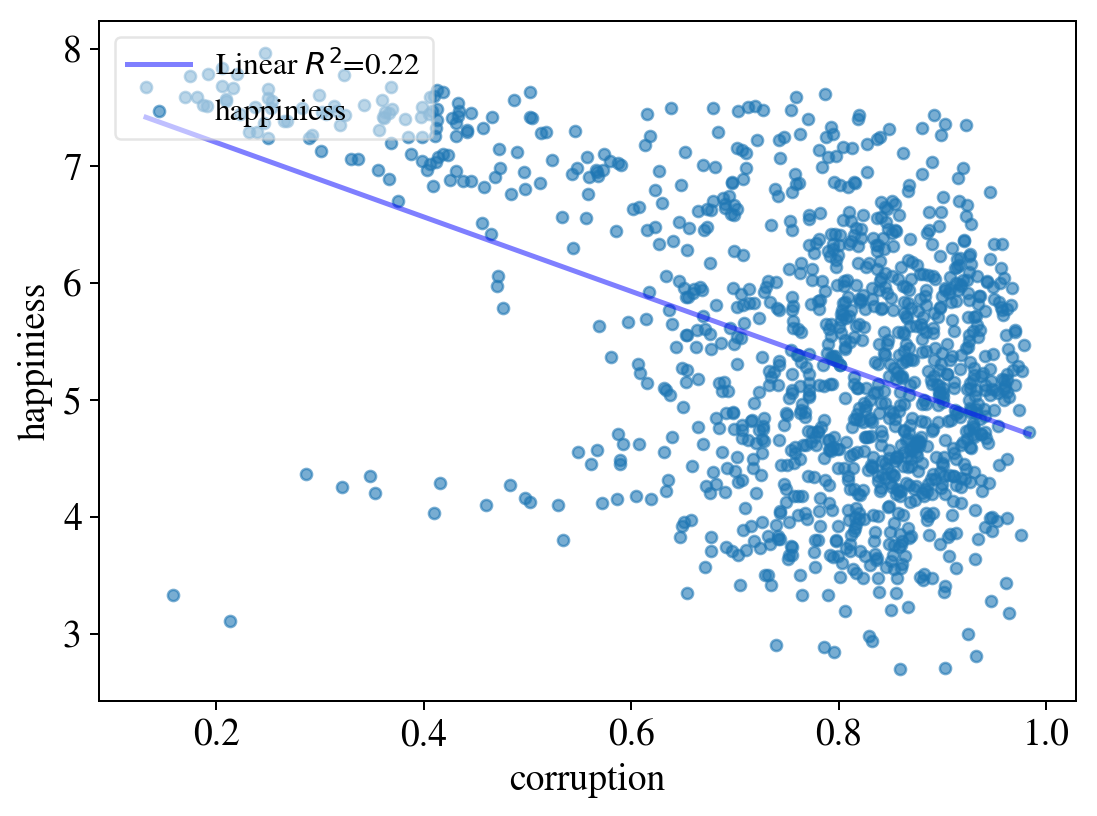






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     77.45
Date:                Thu, 09 May 2019   Prob (F-statistic):           4.91e-18
Time:                        16:09:05   Log-Likelihood:                -1769.7
No. Observations:                1150   AIC:                             3543.
Df Residuals:                    1148   BIC:                             3553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.4002      0.033    162.293    

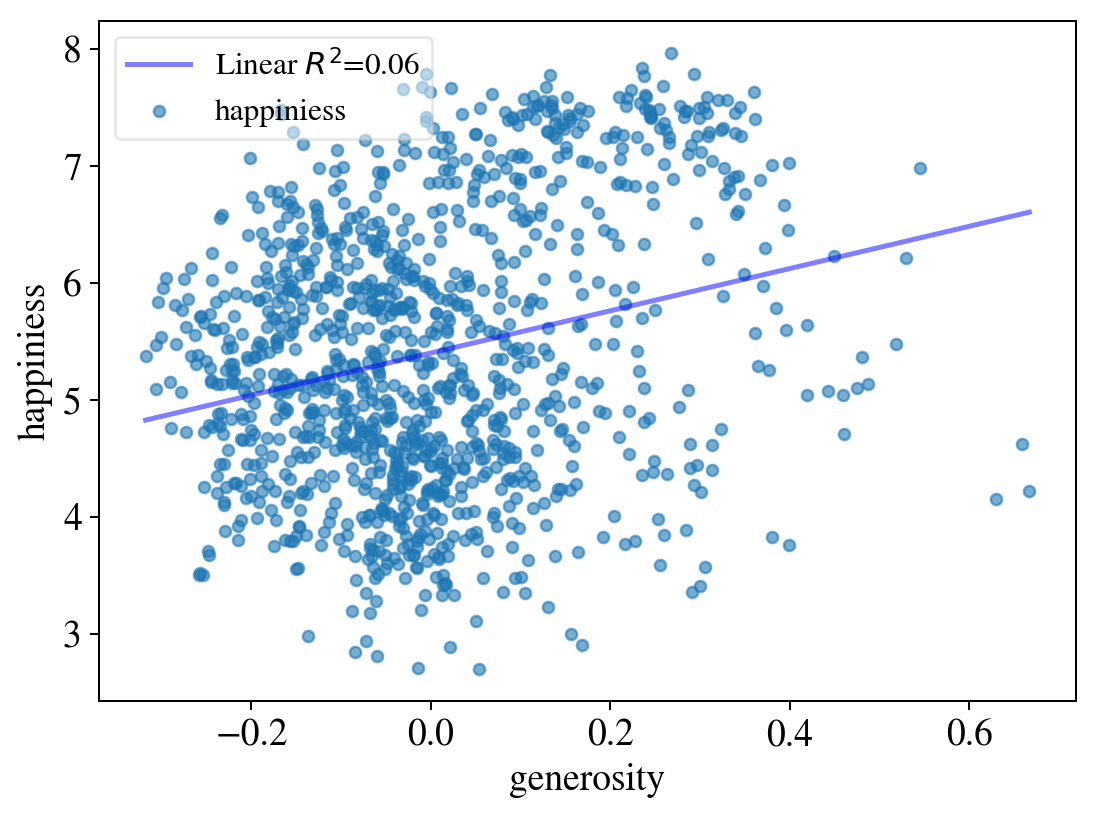






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     496.3
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.17e-91
Time:                        16:09:06   Log-Likelihood:                -1600.6
No. Observations:                1150   AIC:                             3205.
Df Residuals:                    1148   BIC:                             3215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0789      0.152     13.686    

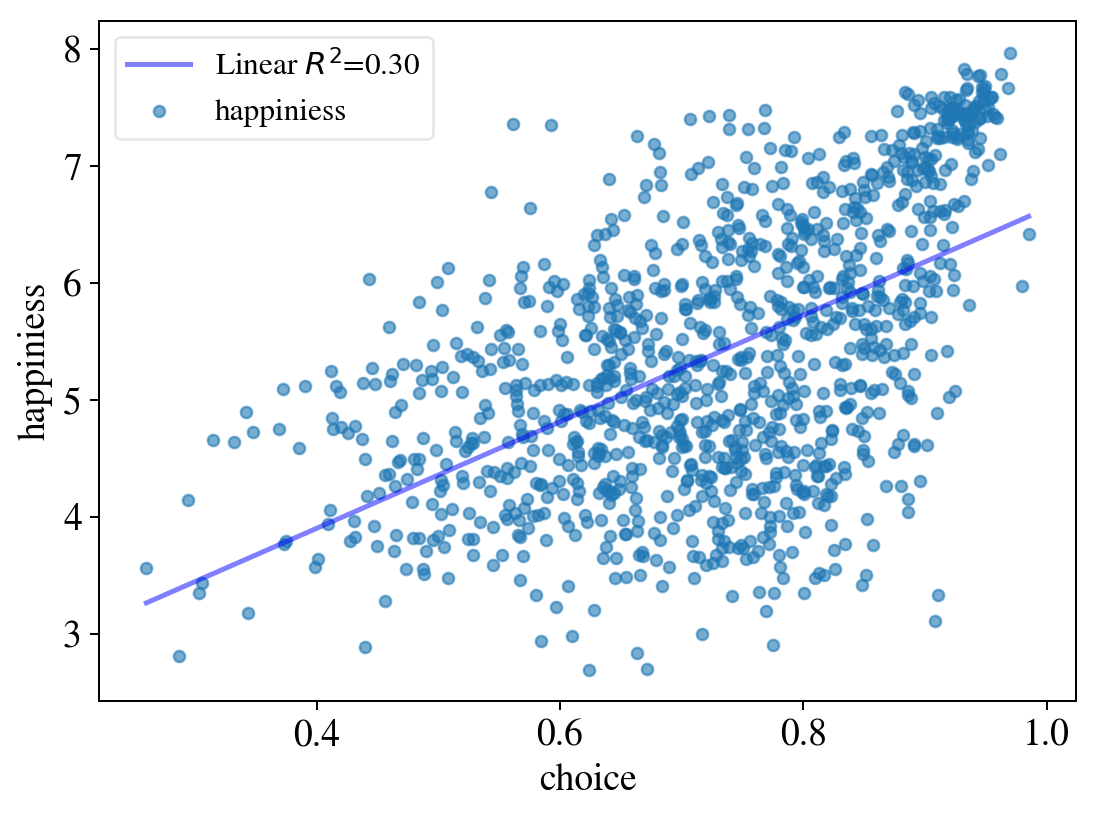






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1632.
Date:                Thu, 09 May 2019   Prob (F-statistic):          9.30e-223
Time:                        16:09:07   Log-Likelihood:                -1298.6
No. Observations:                1150   AIC:                             2601.
Df Residuals:                    1148   BIC:                             2611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -1.5380      0.173     -

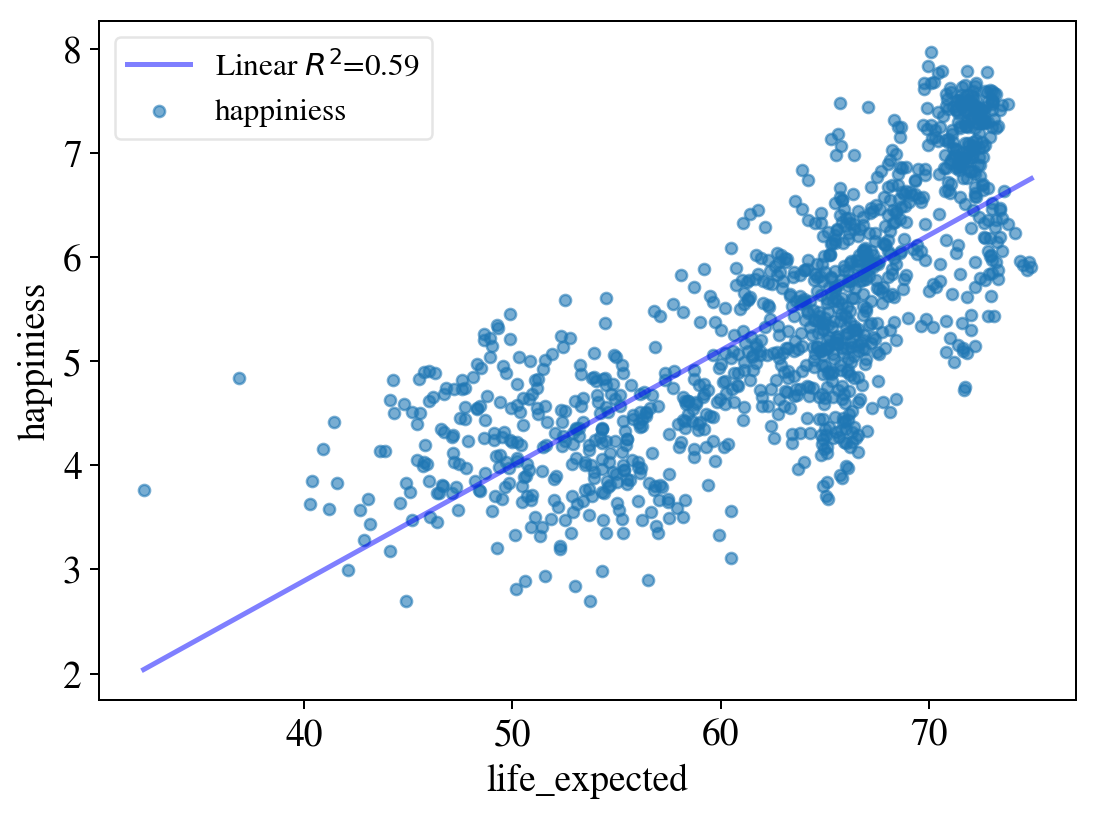






                            OLS Regression Results                            
Dep. Variable:             happiniess   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     37.51
Date:                Thu, 09 May 2019   Prob (F-statistic):           1.25e-09
Time:                        16:09:07   Log-Likelihood:                -1788.7
No. Observations:                1150   AIC:                             3581.
Df Residuals:                    1148   BIC:                             3592.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.5881      0.046    122.755    

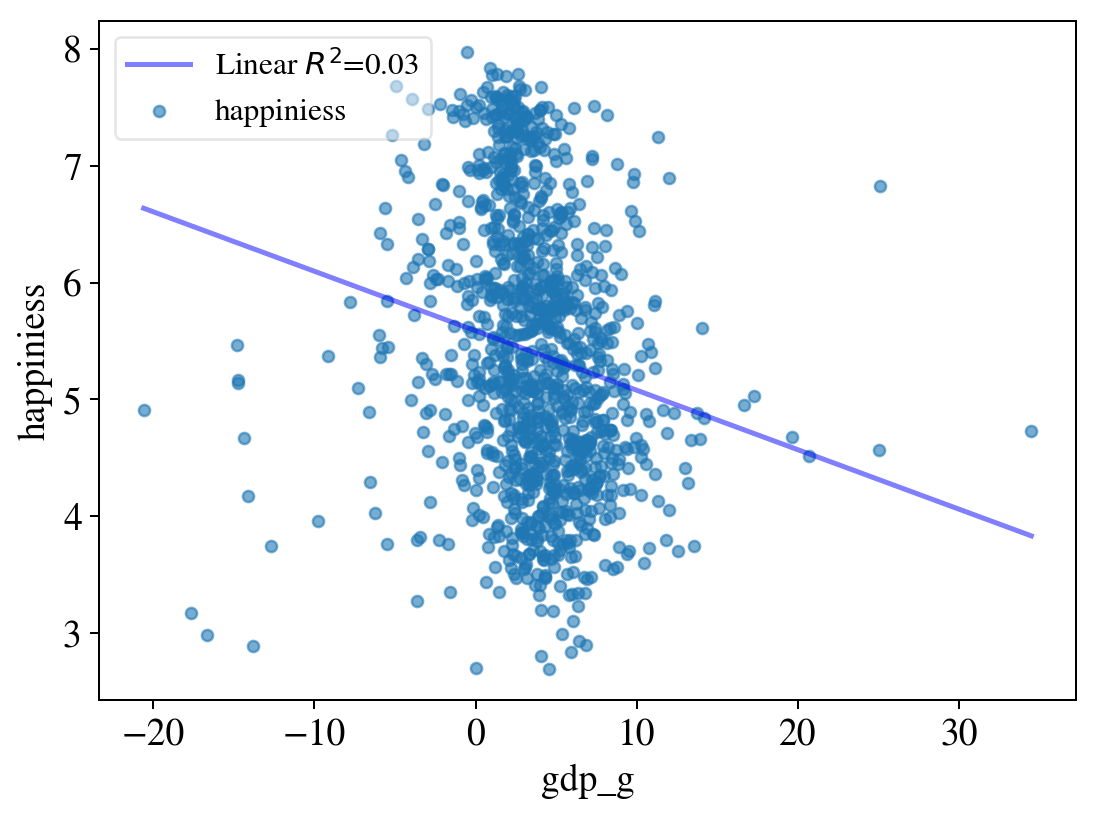

PatsyError: Error evaluating factor: NameError: name 'tax' is not defined
    happiniess ~ 1 + tax
                     ^^^

In [82]:
for feature in fs1[::-1]:
    formula =  'happiniess ~ 1 + ' + feature
    mod = smf.ols(formula=formula, data=data).fit()
    print(mod.summary())
    
    x = pd.DataFrame({feature: np.linspace(data[feature].min(), data[feature].max(), len(data[feature]))})
    plt.scatter( data[feature],  data['happiniess'], s=20, alpha=0.6)
    plt.xlabel(feature); plt.ylabel('happiniess')
    plt.plot(x[feature], mod.predict(x), 'b-', label='Linear $R^2$=%.2f' % mod.rsquared, alpha=0.5)
    plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
    plt.show()    
    print('\n\n\n\n')

In [183]:
fs2 = [s[0] + ' + ' + s[1] for s in set([(x, y) if x > y else (y, x)  for x in fs1 for y in [z for z in fs1 if z != x] ])]
for feature in fs2[::-1]:
    formula =  'happiniess ~ 1 + ' + feature
    mod = smf.ols(formula=formula, data=data).fit()
    print(formula)
    print('rsq = ' + str(mod.rsquared))
    print('aic = ' + str(mod.aic))
    print('\n\n\n')

happiniess ~ 1 + positive + delivery
rsq = 0.6312060717740995
aic = 2473.293954061638




happiniess ~ 1 + life_expected + gov_confidence
rsq = 0.5918023715585736
aic = 2590.0343785654904




happiniess ~ 1 + sd_country_year + negative
rsq = 0.06135462719244433
aic = 3547.62362652104




happiniess ~ 1 + life_expected + gini
rsq = 0.5906661744478213
aic = 2593.230897824145




happiniess ~ 1 + unemployment + generosity
rsq = 0.06384627210300775
aic = 3544.5668794454587




happiniess ~ 1 + tax + positive
rsq = 0.3276032124050783
aic = 3163.996139520188




happiniess ~ 1 + sd_m_country_year + pop
rsq = 0.5736722738659563
aic = 2640.009836694921




happiniess ~ 1 + tax + gdp_g
rsq = 0.04491365402415992
aic = 3567.5922355999155




happiniess ~ 1 + tax + corruption
rsq = 0.22267549657491292
aic = 3330.756806351494




happiniess ~ 1 + negative + democoratic
rsq = 0.4212742213537922
aic = 2991.4732882971693




happiniess ~ 1 + gdp_g + corruption
rsq = 0.241823321557337
aic = 3302.074131

In [209]:
import itertools

all = []

for r in range(2, len(fs1)):
    all = all + [t for t in itertools.combinations(fs1, r)]

len(all)

all

[('year', 'gdp_pc'),
 ('year', 'support'),
 ('year', 'pop'),
 ('year', 'tax'),
 ('year', 'gdp_g'),
 ('year', 'life_expected'),
 ('year', 'choice'),
 ('year', 'generosity'),
 ('year', 'corruption'),
 ('year', 'positive'),
 ('year', 'negative'),
 ('year', 'gov_confidence'),
 ('year', 'democoratic'),
 ('year', 'delivery'),
 ('year', 'sd_country_year'),
 ('year', 'sd_m_country_year'),
 ('year', 'gini'),
 ('year', 'unemployment'),
 ('gdp_pc', 'support'),
 ('gdp_pc', 'pop'),
 ('gdp_pc', 'tax'),
 ('gdp_pc', 'gdp_g'),
 ('gdp_pc', 'life_expected'),
 ('gdp_pc', 'choice'),
 ('gdp_pc', 'generosity'),
 ('gdp_pc', 'corruption'),
 ('gdp_pc', 'positive'),
 ('gdp_pc', 'negative'),
 ('gdp_pc', 'gov_confidence'),
 ('gdp_pc', 'democoratic'),
 ('gdp_pc', 'delivery'),
 ('gdp_pc', 'sd_country_year'),
 ('gdp_pc', 'sd_m_country_year'),
 ('gdp_pc', 'gini'),
 ('gdp_pc', 'unemployment'),
 ('support', 'pop'),
 ('support', 'tax'),
 ('support', 'gdp_g'),
 ('support', 'life_expected'),
 ('support', 'choice'),
 ('supp

In [217]:
def fit(fs):
    f = 'happiniess ~ 1 + ' + ' + '.join(fs)
    return smf.ols(formula=f, data=data).fit()

to_drop = []

In [219]:
fit(fs1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             happiniess   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1023.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:13:15   Log-Likelihood:                -138.79
No. Observations:                1150   AIC:                             317.6
Df Residuals:                    1130   BIC:                             418.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2592      0.185     23.024      0.000       3.896       4.622
year                  0.0018      0.003      0.662      0.508      -0.004       0.007
gdp_pc                0.1089      0.018      6.164      0.000       0.074       0.144
support               0.3326      0.115      2.886      0.004       0.106       0.559
pop               -2.371e-10   9.08e-11     -2.612      0.009   -4.15e-10    -5.9e-11
tax                   0.0008      0.000      2.600      0.009       0.000       0.001
gdp_g                -0.0124      0.002     -5.610      0.000      -0.017      -0.008
life_expected      2.847e-05      0.002      0.013      0.990      -0.004       0.004
choice                0.3217      0.101      3.184      0.001       0.123       0.520
generosity            0.4077      0.063      6.504      0.000       0.285       0.531
corruption           -0.8902      0.072    -12.334      0.000      -1.032      -0.749
positive              0.3757      0.134      2.805      0.005       0.113       0.638
negative              0.6013      0.139      4.316      0.000       0.328       0.875
gov_confidence       -0.2001      0.064     -3.141      0.002      -0.325      -0.075
democoratic          -0.0102      0.023     -0.443      0.658      -0.055       0.035
delivery              0.1302      0.027      4.869      0.000       0.078       0.183
sd_country_year       1.8113      0.046     39.217      0.000       1.721       1.902
sd_m_country_year    -9.1737      0.171    -53.502      0.000      -9.510      -8.837
gini                  0.0503      0.142      0.353      0.724      -0.229       0.330
unemployment         -0.0094      0.002     -5.348      0.000      -0.013      -0.006
==============================================================================
Omnibus:                      378.087   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2420.006
Skew:                           1.362   Prob(JB):                         0.00
Kurtosis:                       9.564   Cond. No.                     2.83e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [251]:
to_drop = [
    'life_expected', 
    'gini',
    'democoratic',
    'year',
    'pop',
    'gdp_g',
    'tax'
]

fit([f for f in fs1 if f not in to_drop]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             happiniess   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1559.
Date:                Sat, 13 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:36:25   Log-Likelihood:                -163.10
No. Observations:                1150   AIC:                             352.2
Df Residuals:                    1137   BIC:                             417.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3094      0.174     24.771      0.000       3.968       4.651
gdp_pc                0.1114      0.015      7.303      0.000       0.081       0.141
support               0.3504      0.116      3.034      0.002       0.124       0.577
choice                0.2904      0.099      2.933      0.003       0.096       0.485
generosity            0.3912      0.061      6.415      0.000       0.272       0.511
corruption           -0.9640      0.071    -13.569      0.000      -1.103      -0.825
positive              0.4226      0.114      3.698      0.000       0.198       0.647
negative              0.6133      0.140      4.377      0.000       0.338       0.888
gov_confidence       -0.2885      0.062     -4.658      0.000      -0.410      -0.167
delivery              0.1208      0.018      6.635      0.000       0.085       0.157
sd_country_year       1.8076      0.044     40.644      0.000       1.720       1.895
sd_m_country_year    -9.1097      0.166    -54.740      0.000      -9.436      -8.783
unemployment         -0.0086      0.002     -4.987      0.000      -0.012      -0.005
==============================================================================
Omnibus:                      408.532   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2855.012
Skew:                           1.461   Prob(JB):                         0.00
Kurtosis:                      10.145   Cond. No.                         350.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""